# Logo Detection

In [1]:
%matplotlib inline
#%reload_ext autoreload   # comment to correct 'PIL.Image' has no attribute 'register_extensions' in Colab
#%autoreload 2            # comment to correct 'PIL.Image' has no attribute 'register_extensions' in Colab

In [2]:
from pathlib import Path
import shutil
import time
import copy
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

0.4.0
True


## Load Data

In [24]:
ROOT = ''
DATA_DIR = os.path.join(ROOT, 'FlickrLogos-v2')
train_mean = np.array([0.44943, 0.4331 , 0.40244])
train_std = np.array([0.29053, 0.28417, 0.30194])

bs = 32 

In [25]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    'valid': transforms.Compose([
        #transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
}


In [26]:
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

In [27]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=bs,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}

In [28]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

In [29]:
class_names = image_datasets['train'].classes

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visulize a few Images

In [31]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = train_std * inp + train_mean
    inp = np.clip(inp, 0, 1)
    #plt.grid(None)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [32]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))  # if ‘PIL.Image’ has no attribute ‘register_extensions, comment out %reload, %autoreload

In [33]:
type(inputs), type(classes)

(torch.Tensor, torch.Tensor)

In [34]:
inputs.size(), classes.size()

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [35]:
# Make a grid from batch
out = utils.make_grid(inputs)

In [36]:
plt.ion()

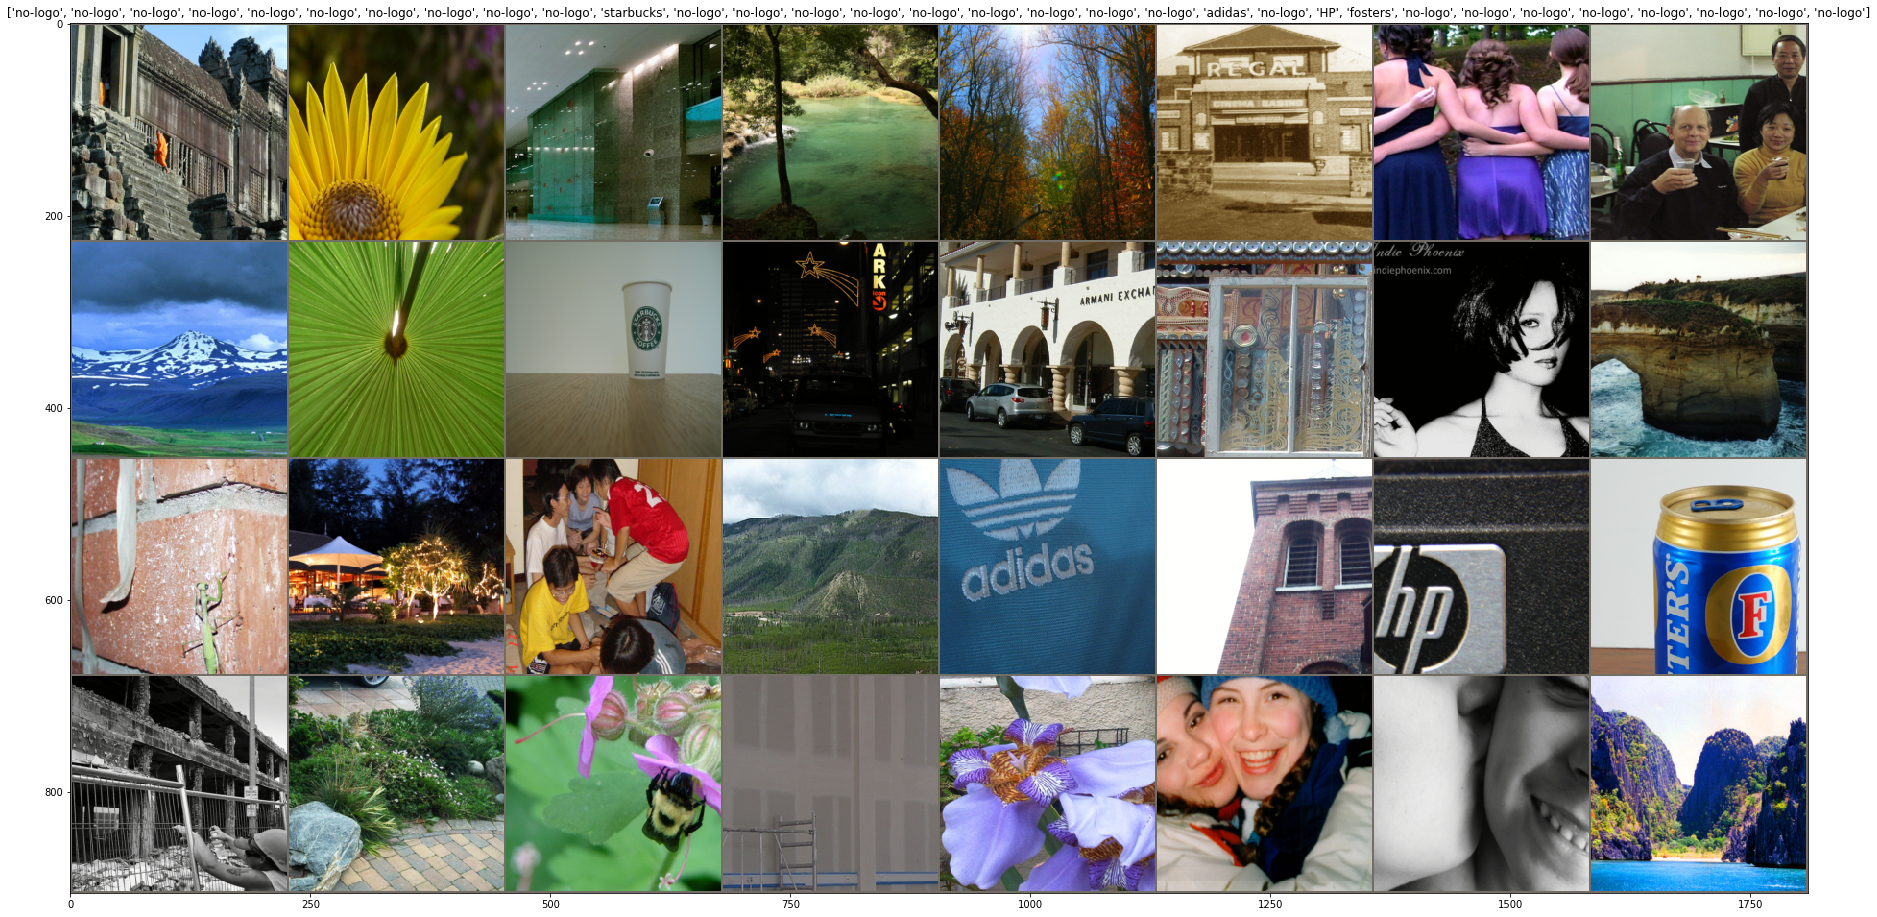

In [89]:
plt.figure(figsize=(32, 16))

imshow(out, title=[class_names[x] for x in classes])

## Training the model

In [38]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the Model Predictions

In [39]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [40]:
def save_model(model, path):
    os.makedirs(os.path.join(DATA_DIR, 'models'), exist_ok=True)
    torch.save(model.state_dict(), os.path.join(DATA_DIR, 'models', path))

In [53]:
def load_model(model, path):
    # model = TheModelClass(*args, **kwargs)
    # map_location https://pytorch.org/docs/master/torch.html#torch.loada
    model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'models', path)))

## Convolutional Neural Network (CNN)

## Define CNN1

In [91]:
import torch.nn as nn
import torch.nn.functional as F


class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, 11, 4)
        self.pool = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(96, 192, 5)
        self.fc1 = nn.Linear(192 * 10 * 10, 4096)
        self.fc2 = nn.Linear(4096, 33)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 192 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [92]:
model_cnn1 = CNN1()
model_cnn1 = model_cnn1.to(device)

## Define a Loss function and optimizer

In [93]:
import torch.optim as optim
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_cnn1.parameters(), lr=lr, momentum=0.9)

## Train the network

In [94]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [95]:
model_cnn1 = train_model(model_cnn1, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4929 Acc: 0.8093
valid Loss: 2.3021 Acc: 0.6098

Epoch 1/24
----------
train Loss: 1.2964 Acc: 0.8242
valid Loss: 2.3803 Acc: 0.6098

Epoch 2/24
----------
train Loss: 1.2614 Acc: 0.8242
valid Loss: 2.2072 Acc: 0.6098

Epoch 3/24
----------
train Loss: 1.2467 Acc: 0.8242
valid Loss: 2.0866 Acc: 0.6098

Epoch 4/24
----------
train Loss: 1.1872 Acc: 0.8231
valid Loss: 2.2040 Acc: 0.6098

Epoch 5/24
----------
train Loss: 1.0574 Acc: 0.8236
valid Loss: 2.0029 Acc: 0.6093

Epoch 6/24
----------
train Loss: 1.0155 Acc: 0.8236
valid Loss: 2.0866 Acc: 0.6098

Epoch 7/24
----------
train Loss: 0.9360 Acc: 0.8264
valid Loss: 2.1734 Acc: 0.6106

Epoch 8/24
----------
train Loss: 0.8975 Acc: 0.8258
valid Loss: 2.0719 Acc: 0.6085

Epoch 9/24
----------
train Loss: 0.8840 Acc: 0.8253
valid Loss: 2.1580 Acc: 0.6106

Epoch 10/24
----------
train Loss: 0.8722 Acc: 0.8242
valid Loss: 1.9719 Acc: 0.6114

Epoch 11/24
----------
train Loss: 0.8389 Acc: 0.8275
valid Loss

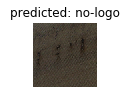

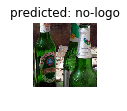

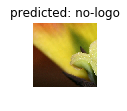

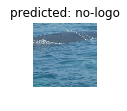

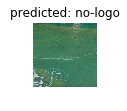

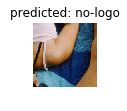

In [96]:
visualize_model(model_cnn1)

In [97]:
save_model(model_cnn1, 'model_cnn1.pkl')

In [98]:
device

device(type='cuda', index=0)

In [99]:
load_model(model_cnn1, 'model_cnn1.pkl')

## Define CNN2

In [100]:
import torch.nn as nn
import torch.nn.functional as F


class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 33)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [101]:
model_cnn2 = CNN2()
model_cnn2 = model_cnn2.to(device)

## Define a Loss function and optimizer

In [102]:
import torch.optim as optim
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_cnn2.parameters(), lr=lr, momentum=0.9)

## Train the network

In [103]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [104]:
model_cnn2 = train_model(model_cnn2, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.8080 Acc: 0.7929
valid Loss: 2.1852 Acc: 0.6098

Epoch 1/24
----------
train Loss: 1.2530 Acc: 0.8242
valid Loss: 2.0535 Acc: 0.6098

Epoch 2/24
----------
train Loss: 1.1793 Acc: 0.8242
valid Loss: 2.3499 Acc: 0.6098

Epoch 3/24
----------
train Loss: 1.0859 Acc: 0.8242
valid Loss: 2.0551 Acc: 0.6098

Epoch 4/24
----------
train Loss: 1.0616 Acc: 0.8242
valid Loss: 2.0898 Acc: 0.6098

Epoch 5/24
----------
train Loss: 1.0983 Acc: 0.8242
valid Loss: 2.1828 Acc: 0.6098

Epoch 6/24
----------
train Loss: 1.0856 Acc: 0.8242
valid Loss: 2.1004 Acc: 0.6098

Epoch 7/24
----------
train Loss: 1.0526 Acc: 0.8242
valid Loss: 2.2103 Acc: 0.6098

Epoch 8/24
----------
train Loss: 1.0423 Acc: 0.8242
valid Loss: 2.1193 Acc: 0.6098

Epoch 9/24
----------
train Loss: 1.0359 Acc: 0.8242
valid Loss: 2.1162 Acc: 0.6098

Epoch 10/24
----------
train Loss: 1.0224 Acc: 0.8242
valid Loss: 2.1461 Acc: 0.6098

Epoch 11/24
----------
train Loss: 1.0187 Acc: 0.8242
valid Loss

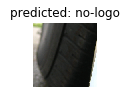

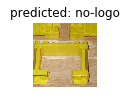

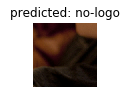

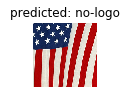

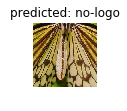

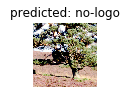

In [105]:
visualize_model(model_cnn2)

In [106]:
save_model(model_cnn2, 'model_cnn2.pkl')

In [107]:
load_model(model_cnn2, 'model_cnn2.pkl')

## Finetuning the Convnet

In [62]:
model_ft = models.resnet18(pretrained=True)

In [63]:
num_ftrs = model_ft.fc.in_features

In [64]:
num_ftrs

512

In [65]:
model_ft.fc = nn.Linear(num_ftrs, 33)

In [66]:
model_ft = model_ft.to(device)

In [67]:
criterion = nn.CrossEntropyLoss()

In [68]:
# Observe that all parameters are being optimized
lr = 0.001
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)

In [69]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [70]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2852 Acc: 0.7654
valid Loss: 1.7760 Acc: 0.6110

Epoch 1/24
----------
train Loss: 0.7051 Acc: 0.8280
valid Loss: 1.7546 Acc: 0.6146

Epoch 2/24
----------
train Loss: 0.6570 Acc: 0.8330
valid Loss: 1.7060 Acc: 0.6244

Epoch 3/24
----------
train Loss: 0.6259 Acc: 0.8434
valid Loss: 1.6876 Acc: 0.6329

Epoch 4/24
----------
train Loss: 0.5718 Acc: 0.8571
valid Loss: 1.6046 Acc: 0.6541

Epoch 5/24
----------
train Loss: 0.5369 Acc: 0.8819
valid Loss: 1.5474 Acc: 0.6699

Epoch 6/24
----------
train Loss: 0.4818 Acc: 0.8995
valid Loss: 1.4743 Acc: 0.6764

Epoch 7/24
----------
train Loss: 0.4330 Acc: 0.9137
valid Loss: 1.4553 Acc: 0.6850

Epoch 8/24
----------
train Loss: 0.4394 Acc: 0.9104
valid Loss: 1.4810 Acc: 0.6789

Epoch 9/24
----------
train Loss: 0.4225 Acc: 0.9220
valid Loss: 1.4486 Acc: 0.6862

Epoch 10/24
----------
train Loss: 0.4270 Acc: 0.9154
valid Loss: 1.5331 Acc: 0.6752

Epoch 11/24
----------
train Loss: 0.4398 Acc: 0.9143
valid Loss

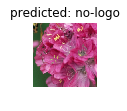

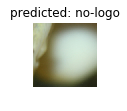

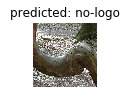

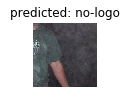

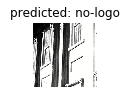

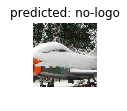

In [71]:
visualize_model(model_ft)

In [72]:
save_model(model_ft, 'model_ft.pkl')

In [73]:
device

device(type='cuda', index=0)

In [74]:
load_model(model_ft, 'model_ft.pkl')

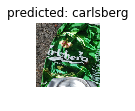

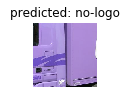

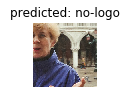

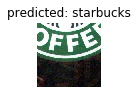

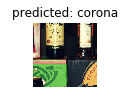

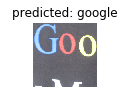

In [90]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

In [77]:
# Parameters of newly constructed modules have requires_grad=True by default
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [78]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 33)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
lr = 0.001
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=lr, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

In [79]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1804 Acc: 0.7951
valid Loss: 1.8110 Acc: 0.6118

Epoch 1/24
----------
train Loss: 0.7672 Acc: 0.8269
valid Loss: 1.7263 Acc: 0.6159

Epoch 2/24
----------
train Loss: 0.7085 Acc: 0.8286
valid Loss: 1.7360 Acc: 0.6187

Epoch 3/24
----------
train Loss: 0.6498 Acc: 0.8429
valid Loss: 1.6716 Acc: 0.6256

Epoch 4/24
----------
train Loss: 0.6200 Acc: 0.8549
valid Loss: 1.6365 Acc: 0.6333

Epoch 5/24
----------
train Loss: 0.5881 Acc: 0.8643
valid Loss: 1.5933 Acc: 0.6415

Epoch 6/24
----------
train Loss: 0.5709 Acc: 0.8632
valid Loss: 1.5000 Acc: 0.6573

Epoch 7/24
----------
train Loss: 0.5187 Acc: 0.8786
valid Loss: 1.5089 Acc: 0.6557

Epoch 8/24
----------
train Loss: 0.5277 Acc: 0.8780
valid Loss: 1.5108 Acc: 0.6553

Epoch 9/24
----------
train Loss: 0.5285 Acc: 0.8874
valid Loss: 1.5134 Acc: 0.6561

Epoch 10/24
----------
train Loss: 0.5188 Acc: 0.8841
valid Loss: 1.5008 Acc: 0.6557

Epoch 11/24
----------
train Loss: 0.5151 Acc: 0.8907
valid Loss

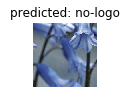

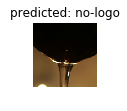

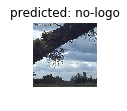

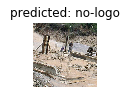

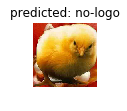

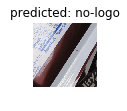

In [81]:
visualize_model(model_conv)

In [82]:
save_model(model_conv, 'model_conv.pkl')

In [83]:
load_model(model_conv, 'model_conv.pkl')

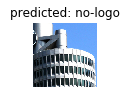

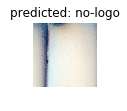

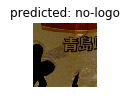

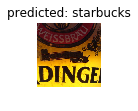

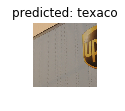

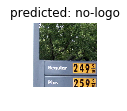

In [84]:
visualize_model(model_conv)